<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>DM-44388: Filtered Trails Investigation Notebook</b> <br>
Contact author: Brianna Smart<br>
Last verified to run: -  05/15/2024<br>
LSST Science Piplines version: - r26.0.2 Large Container<br>
Container Size: Large <br># Clean Notebook

## Table of Contents

1. [Introduction](#Introduction)
2. [Conclusions](#Conclusions)
3. [Setup](#Setup)
4. [Load Data](#Load-Data)
5. [Inspecting Columns](#Inspecting-Columns)
6. [Investigate Trail Measurements](#Investigate-Trail-Measurements)
7. [Scratchwork](#Scratchwork)

# Introduction
The goal of this notebook is to inspect the output trailed source tables from Ops Rehearsal 3 and determine what kinds of sources are being filtered out of the catalog and if any of the sources should not have been caught in the filter.

During Ops Rehearsal 3, a significant number of sources were filtered out by the trailed source filter. However, the majority of these sources appear to not be trailed sources at all, but point sources which have been erroneously flagged.


# Conclusions

The majority of the sources in the trailed source catalog are not trailed sources at all, but point sources which had the `unweighted` Sdss flag set along with the `edge` flag set in the trailed source measurement plugin. Looking into this, it was noted that there were several compounding issues. The first is that any sources with the shape flag set should result in a retun in the plugin, indicating no trailed measurement will be made. However, we were using the `HSMShape` flag, but using `SdssShape` was hardcoded into the plugin. This resulted in several sources getting though which should not have been measured. Additionally, these sources had the `unweighted` flag set for `SdssShape`, meaning that they did not go through the length measurement which checked for convergence and valid results. This resulted in sources with a trail length of `nan` which were treated as valid trailed sources, with the rest of their values being calculated and flags set if their coordinates lied on edge pixels. These point sources were then filtered out later.

The few sources that were valid did have either the correct edge flag set or were longer than 12.5 arcseconds in length, the cutoff for trailed sources allowed in the catalog. Data from the next ops rehearsal will show us more clearly how well the filtering is working.

## Setup

In [6]:
import pandas as pd
import numpy as np
# Basic imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd
from IPython.display import Image, display
from lsst.daf.butler import DatasetNotFoundError

from astropy.coordinates import SkyCoord

import lsst.geom
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import legacyPlotUtils as plac
from lsst.analysis.ap import PlotImageSubtractionCutoutsTask
from lsst.analysis.ap.nb_utils import make_simbad_link
from lsst.analysis.ap import apdb
from lsst.analysis.ap.plotImageSubtractionCutouts import PlotImageSubtractionCutoutsTask as plotCutouts


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

importlib.reload(utils)

bandList = ['i', 'z', 'y']
colorList = ['C2', 'C3', 'C5', 'k']
import lsst.afw.display as afwDisplay
from IPython.display import IFrame
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import gc

In [7]:
def m_and_v_plots (exposure, matplot=None, display_num=None, record=None):
    """
    Create an array of plots with their mask and variance

    Parameters
    ----------
    datasetRefs: a set of DataSetRefs
    returned by the butler
    matplot: Can be set to True
    display_num: Integer setting number of images

    Returns
    -------
    None
    """
    
    if display_num == None:
        display_num=1
    else:
        display_num=display_num
    
    if matplot != None:
        afwDisplay.setDefaultBackend('matplotlib') 
        
        print('Visit: ', exposure.visitInfo.getId(), ', Detector: ', exposure.detector.getId())
        fig, ax = plt.subplots(1, 3, figsize=(14, 7))
        plt.sca(ax[0])  # set the first axis as current
        plt.xlabel('Image with Mask Overlay')
        display1 = afwDisplay.Display(frame=fig)
        display1.scale('asinh', -1, 30)
        display1.mtv(exposure)
        plt.sca(ax[1])  # set the second axis as current
        display2 = afwDisplay.Display(frame=fig)
        display2.mtv(exposure.mask)
        plt.tight_layout()
        plt.sca(ax[2]) 
        display3 = afwDisplay.Display(frame=fig)
        display3.scale('asinh', 'zscale')
        display3.mtv(exposure.variance)
        plt.tight_layout()
        plt.show()
        remove_figure(fig)

    else:
        afwDisplay.setDefaultBackend('firefly')

        print('Visit: ', exposure.visitInfo.getId(), ', Detector: ',exposure.detector.getId())
        display = afwDisplay.Display(frame=0)
        display.scale('asinh', -1, 30)
        display.mtv(exposure)
        display = afwDisplay.Display(frame=1)
        display.setMaskTransparency(90)
        display.mtv(exposure.mask)
        display = afwDisplay.Display(frame=2)
        display.scale('asinh', 'zscale')
        display.mtv(exposure.variance)

    if record is not None:
        display1.dot('x', record.getX(),record.getY())
        display2.dot('x', record.getX(),record.getY())
        display3.dot('x', record.getX(),record.getY())

In [8]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [9]:
def plot_stamps(filename, pixel_max=3200, pixel_min=200, sourceId = None, return_alert = False):
    # Can take a single sourceId or look at all of them for a range of pixel dimensions. Can also return the packet if 
    with open(filename,'rb') as f:
        try:
            freader = fastavro.reader(f)
            for packet in freader:
                image_data = packet['cutoutDifference']
                if sourceId is not None:
                    if packet['diaSource']['diaSourceId'] != sourceId:
                        continue
                    else:
                        print("source_found")
                        if return_alert: 
                            return packet
                with io.BytesIO(image_data) as bytesIO:
                    cutoutFromBytes = CCDData.read(bytesIO, format="fits")
                bbox = cutoutFromBytes.shape
                if bbox[0] >=pixel_min and bbox[1] >= pixel_min and bbox[0] <= pixel_max and bbox[1] <= pixel_max:
                    plt.figure()
                    source = apdbQuery.load_source(packet['diaSource']['diaSourceId'])
                    dataId ={'detector':source['detector'],'visit': source['visit']}
                    catalog = butler.get(f'goodSeeingDiff_diaSrc', dataId)
                    record = catalog.find(packet['diaSource']['diaSourceId'])
                    print('-----------------------------------------------')
                    print(filename)
                    print("DiaSource Id: ", packet['diaSource']['diaSourceId'])
                    print("Bounding Box: ", bbox)
                    print("Centroid: ", record.getX(), record.getY())
                    print("Interpolated Flag: ", record['base_PixelFlags_flag_interpolated'])
                    print("Saturated Flag: ", record['base_PixelFlags_flag_saturated'])
                    print("Trailed Source Flag: ", record['ext_trailedSources_Naive_flag'])
                    length_check = record['ext_trailedSources_Naive_length']
                    print("Trailed Source Length more than limit: ", )
                    print("Dipole Flux Flag: ", record['ip_diffim_PsfDipoleFlux_flag'])
                    print("Dipole Flux Centroid: ", record['ip_diffim_NaiveDipoleCentroid_x'],record['ip_diffim_NaiveDipoleCentroid_y'])
                    x_dipole_sep=record['ip_diffim_NaiveDipoleCentroid_pos_x']-record['ip_diffim_NaiveDipoleCentroid_neg_x']
                    y_dipole_sep=record['ip_diffim_NaiveDipoleCentroid_pos_y']-record['ip_diffim_NaiveDipoleCentroid_neg_y']
                    print("Seperation of x and y dipole coords: ", [x_dipole_sep,y_dipole_sep])
                    plt.imshow(cutoutFromBytes, vmin=-1, vmax=30)
        except:
            out=1
            # print(filename + " not a data packet")
            #print("")

In [10]:
def plot_footprint(detector, visit, source_id, dataSetType):
    #Modified plot footprint code which works with the Ops3 rehearsal data
    
    calexp=butler.get('goodSeeingDiff_differenceExp', visit = 7024040400780, detector = 0)
    catalog = butler.get(dataSetType, visit = visit, detector = detector)
    record = catalog.find(source_id)
    footprint = record.getFootprint()
    print(footprint)
    cutout_calexp = calexp.subset(footprint.getBBox())
    print("Footprint bounding box: ", footprint.getBBox())
    print("Centroid from record = ", record.getX(), record.getY())
    m_and_v_plots(cutout_calexp, display_num=0, matplot=True, record=record)
    print(record)


## Load Data

In [11]:
repo = '/repo/embargo'
collections = 'u/elhoward/DM-44138/LSSTComCamSim'
instrument = 'LSSTComCamSim'

butler = dafButler.Butler(repo, collections=collections, instrument=instrument)
registry = butler.registry

Load up all trailed source tables produces. Many of them are empty.

In [12]:
all_trailed_sources=butler.registry.queryDatasets('goodSeeingDiff_longTrailedSrc', collections=collections)

In [13]:
len(list(all_trailed_sources))

20785

In [14]:
metrics=butler.get('trailedDiaSrcCore_metrics', detector=0, visit=7024040200003)

In [15]:
metrics

{'numDiaSourcesAll': [Measurement('numTrailedDiaSrc', <Quantity 3. ct>)]}

In [19]:
for visit in range (7024040200000,7024040200003):
    try:
        bundle = butler.get('diffimMetadata_metrics', detector = 0, visit = visit)
    except DatasetNotFoundError:
        continue
    else:
        metricList = bundle.get('diffimMetadataMetric')
    test = [item.metric_name.metric for item in metricList]
    print(test)

['nUnmergedDiaSources', 'nMergedDiaSources', 'nGoodPixels', 'nBadPixels', 'nPixelsDetectedPositive', 'nPixelsDetectedNegative', 'nBadPixelsDetectedPositive', 'nBadPixelsDetectedNegative', 'sciencePsfSize', 'templatePsfSize', 'scaleScienceVarianceFactor', 'scaleTemplateVarianceFactor', 'templateCoveragePercent']
['nUnmergedDiaSources', 'nMergedDiaSources', 'nGoodPixels', 'nBadPixels', 'nPixelsDetectedPositive', 'nPixelsDetectedNegative', 'nBadPixelsDetectedPositive', 'nBadPixelsDetectedNegative', 'sciencePsfSize', 'templatePsfSize', 'scaleScienceVarianceFactor', 'scaleTemplateVarianceFactor', 'templateCoveragePercent']


In [20]:
metrics.get('numDiaSourcesAll')[0]

Measurement('numTrailedDiaSrc', <Quantity 3. ct>)

In [21]:
one_metricbundle = butler.get('diffimMetadata_metrics', detector=0,visit=7024040200003)

In [22]:
count= 0
for id in all_trailed_sources.dataIds:
    metrics=butler.get('trailedDiaSrcCore_metrics', detector=id['detector'], visit=id['visit'])
    count+=metrics.get('numDiaSourcesAll')[0].quantity.value

Count all filtered out sources from the Ops Rehearsal 3 data. This includes all the genuine sources along with the mistakenly captured point sources

In [29]:
count

32398.0

Count all sources in the trailed source catalog for visits 

In [30]:
count= 0
for visit in range (7024040200000,7024040300020):
    try:
        metrics = butler.get('trailedDiaSrcCore_metrics', detector = 0, visit = visit)
    except DatasetNotFoundError:
        continue
    else:
        count+=metrics.get('numDiaSourcesAll')[0].quantity.value
print(count)

964.0


For visit in range (7024040200000,7024040300020), we have 964 trailed sources filtered out. However, of those, only a few were actual trailed sources

In [26]:
metrics

{'numDiaSourcesAll': [Measurement('numTrailedDiaSrc', <Quantity 5. ct>)]}

In [27]:
all_trailed_sources=butler.registry.queryDatasets('goodSeeingDiff_longTrailedSrc', collections=collections)

In [28]:
list(all_trailed_sources)

[DatasetRef(DatasetType('goodSeeingDiff_longTrailedSrc', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame), {instrument: 'LSSTComCamSim', detector: 2, visit: 7024040300346, band: 'r', day_obs: 20240403, physical_filter: 'r_03'}, run='u/elhoward/DM-44138/LSSTComCamSim/20240510T175057Z', id=2bb65b4f-8e92-4d9a-86bd-cda370179b63),
 DatasetRef(DatasetType('goodSeeingDiff_longTrailedSrc', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame), {instrument: 'LSSTComCamSim', detector: 2, visit: 7024040300599, band: 'i', day_obs: 20240403, physical_filter: 'i_06'}, run='u/elhoward/DM-44138/LSSTComCamSim/20240510T175057Z', id=c3de9f1c-9b2e-41c0-9ab1-33151ab5f7c3),
 DatasetRef(DatasetType('goodSeeingDiff_longTrailedSrc', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame), {instrument: 'LSSTComCamSim', detector: 5, visit: 7024040300715, band: 'i', day_obs: 20240403, physical_filter: 'i_06'}, run='u/elhoward/DM-44138/LSSTComCamSim/20

 DatasetRef(DatasetType('goodSeeingDiff_longTrailedSrc', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame), {instrument: 'LSSTComCamSim', detector: 0, visit: 7024040200737, band: 'i', day_obs: 20240402, physical_filter: 'i_06'}, run='u/elhoward/DM-44138/LSSTComCamSim/20240510T175057Z', id=530a64d4-1169-413d-add0-a7390597f612),

# Inspecting Columns

To determine why a large number of the filtered sources contain nan trails, we inspected the columns and flags to see if we could find a pattern.

In [29]:
data = butler.get('goodSeeingDiff_diaSrc', detector = 0, visit = 7024040200001).asAstropy()

In [30]:
data.columns

<TableColumns names=('id','coord_ra','coord_dec','parent','coord_raErr','coord_decErr','coord_ra_dec_Cov','flags_negative','deblend_nChild','deblend_deblendedAsPsf','deblend_psfCenter_x','deblend_psfCenter_y','deblend_psf_instFlux','deblend_tooManyPeaks','deblend_parentTooBig','deblend_masked','deblend_failed','deblend_skipped','deblend_rampedTemplate','deblend_patchedTemplate','deblend_hasStrayFlux','deblend_peak_center_x','deblend_peak_center_y','deblend_peakId','deblend_nPeaks','deblend_parentNPeaks','detect_isPrimary','detect_isDeblendedSource','detect_fromBlend','detect_isIsolated','base_SdssCentroid_x','base_SdssCentroid_y','base_SdssCentroid_xErr','base_SdssCentroid_yErr','base_SdssCentroid_flag','base_CircularApertureFlux_flag_badCentroid','base_GaussianFlux_flag_badCentroid','base_PeakLikelihoodFlux_flag_badCentroid','base_PsfFlux_flag_badCentroid','base_SdssShape_flag_badCentroid','ext_shapeHSM_HsmPsfMoments_flag_badCentroid','ext_shapeHSM_HsmSourceMoments_flag_badCentroid','

In [31]:
data['ext_trailedSources_Naive_length']

nan
8.37861515241461
3.7472153670704493
nan
2.696608249027258
nan
nan
nan
0.3050389262232474
nan
nan


In [35]:
count= 0
for visit in range (7024040200000,7024040250020):
    try:
        data = butler.get('goodSeeingDiff_longTrailedSrc', detector = 0, visit = visit)
    except DatasetNotFoundError:
        continue
    else:
        if data['trailLength'].any():
            print(data['trailLength'])

0         NaN
1    1.533029
Name: trailLength, dtype: float64
0    1.663312
Name: trailLength, dtype: float64


From looking at just one detector over all visits, it looks like trails which exceed the length limits are being caught, as well as numerous nan sources. These nan trails should not be caught at all.

In [36]:
count= 0
for visit in range (7024040200000,7024040500500):
    try:
        data = butler.get('goodSeeingDiff_longTrailedSrc', detector = 0, visit = visit)
    except DatasetNotFoundError:
        continue
    else:
        if data['trailLength'].any():
            print(data['trailLength'])
            print(data['trail_flag_edge'])

0         NaN
1    1.533029
Name: trailLength, dtype: float64
0    True
1    True
Name: trail_flag_edge, dtype: bool
0    1.663312
Name: trailLength, dtype: float64
0    True
Name: trail_flag_edge, dtype: bool
0    1.972324
1         NaN
2         NaN
Name: trailLength, dtype: float64
0    True
1    True
2    True
Name: trail_flag_edge, dtype: bool
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8     15.171376
9           NaN
10          NaN
Name: trailLength, dtype: float64
0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8     False
9      True
10     True
Name: trail_flag_edge, dtype: bool
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10    14.537347
11          NaN
12          NaN
13          NaN
14          NaN
15          NaN
16          NaN


# Investigate Trail Measurements

Test loading trailed source count from detector 0, visit 7024040200003

In [ ]:
We see here three correctly filtered trailed sources which are longer than 12.5 arcseconds, which is the maximum trail length allowed for a 30 second exposure. The rest of the sources may be edge sources which do not have trails but still ended up with the 

The maximum trail length should be 36000/3600.0/24.0*30, which is 12.5 arcseconds.

In [19]:
data['dec']

0   -47.589607
1   -47.697461
Name: dec, dtype: float64

In [20]:
data['trailDec']

0   -47.589599
1   -47.697470
Name: trailDec, dtype: float64

In [21]:
data['trailRa']

0    280.146787
1    279.940903
Name: trailRa, dtype: float64

In [22]:
data['trailFlux']

0     -8014.669628
1    664489.219988
Name: trailFlux, dtype: float64

In [23]:
data['shape_flag']

0    False
1    False
Name: shape_flag, dtype: bool

In [26]:
data['trail_flag_edge']

0    True
1    True
Name: trail_flag_edge, dtype: bool

In [208]:
data.columns

Index(['diaSourceId', 'visit', 'detector', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize', 'time_processed',
       'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov', 'x', 'y', 'xErr', 'yErr',
       'apFlux', 'apFluxErr', 'snr', 'psfFlux', 'psfFluxErr', 'psfChi2',
       'psfNdata', 'trailFlux', 'trailRa', 'trailDec', 'trailLength',
       'trailAngle', 'dipoleMeanFlux', 'dipoleMeanFluxErr', 'dipoleFluxDiff',
       'dipoleFluxDiffErr', 'dipoleLength', 'dipoleAngle', 'dipoleChi2',
       'isDipole', 'dipoleNdata', 'scienceFlux', 'scienceFluxErr', 'ixx',
       'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'reliability', 'pixelFlags',
       'pixelFlags_offimage', 'pixelFlags_edge', 'pixelFlags_interpolated',
       'pixelFlags_saturated', 'pixelFlags_cr', 'pixelFlags_bad',
       'pixelFlags_suspect', 'pixelFlags_interpolatedCenter',
       'pixelFlags_saturatedCenter', 'pixelFlags_crCenter',
       'pixelFlags_suspectCenter', 'centroid_flag', '

In [14]:
data

,diaSourceId,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,...,shape_flag_no_pixels,shape_flag_not_contained,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter
0,3065509624502288434,7024040400780,0,r,0,0,0,60405.424882,35,2024-05-09 23:02:29.605506,...,False,False,False,True,False,False,False,False,False,False


6 peaks, area=539, centroid=(978.312, 407.824)
Footprint bounding box:  (minimum=(961, 393), maximum=(992, 422))
Centroid from record =  978.1577969429278 408.4433506237532
Visit:  7024040400780 , Detector:  0


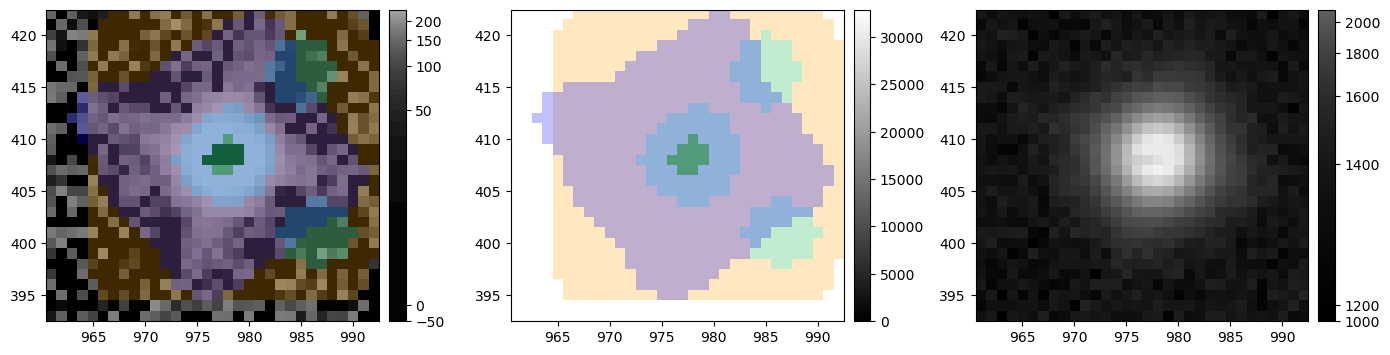

id: 3065509624502288434
coord_ra: 5.23138 rad
coord_dec: -0.711712 rad
parent: 0
coord_raErr: 8.31525e-09
coord_decErr: 1.47874e-08
coord_ra_dec_Cov: -1.35533e-17
flags_negative: 0
deblend_nChild: 0
deblend_deblendedAsPsf: 0
deblend_psfCenter_x: nan
deblend_psfCenter_y: nan
deblend_psf_instFlux: nan
deblend_tooManyPeaks: 0
deblend_parentTooBig: 0
deblend_masked: 0
deblend_failed: 0
deblend_skipped: 0
deblend_rampedTemplate: 0
deblend_patchedTemplate: 0
deblend_hasStrayFlux: 0
deblend_peak_center_x: 0
deblend_peak_center_y: 0
deblend_peakId: 0
deblend_nPeaks: 0
deblend_parentNPeaks: 0
detect_isPrimary: 0
detect_isDeblendedSource: 0
detect_fromBlend: 0
detect_isIsolated: 0
base_SdssCentroid_x: 975.284
base_SdssCentroid_y: 409.916
base_SdssCentroid_xErr: 0.01117
base_SdssCentroid_yErr: 0.0153536
base_SdssCentroid_flag: 0
base_SdssCentroid_flag_edge: 0
base_SdssCentroid_flag_noSecondDerivative: 0
base_SdssCentroid_flag_almostNoSecondDerivative: 0
base_SdssCentroid_flag_notAtMaximum: 0
base

In [108]:
plot_footprint(0, 7024040400780, 3065509624502288434,'goodSeeingDiff_diaSrc')

The above source is a point source which happens to fall on edge pixels. It this gets flagged and filtered out, despute it not containing a trail length. Note that it also had the unwighted Sdss shape flag set, which allowed it to get an invalid trail length and continue on in the trail measurement code instead of falling out and being marked as a non-trailed source. This appears to be the main source of the eronously flagged point sources.

# Scratchwork

In [104]:
calexp=butler.get('goodSeeingDiff_differenceExp', visit = 7024040400780, detector = 0)

In [109]:
catalog = butler.get('goodSeeingDiff_diaSrc', visit = 7024040400780, detector = 0)
record = catalog.find(3065509624502288434)

In [85]:
catalog = butler.get('goodSeeingDiff_diaSrc', visit = 7024040400780, detector = 0)

In [86]:
record=catalog.find(3065509624502288434)

In [87]:
footprint=record.getFootprint()

In [88]:
bbox=footprint.getBBox()

In [90]:
bbox

Box2I(corner=Point2I(961, 393), dimensions=Extent2I(32, 30))

In [84]:
dataframe = butler.get('goodSeeingDiff_diaSrc', visit = 7024040400780, detector = 0)

In [76]:
bbox_sources=dataframe.bboxSize

In [115]:
record.getShapeErr()

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

Looking at the record, we can see multiple unusual things going on, specifically with the shape flags. This source has the Sdssshape flag set, however it was still processed and not immediatly returned. However, the shape flag it was using was not the SdssShape flag but the HSM flag. This, combined with manual usage of Sdss measurements, started some of the problems. Additionally, with the flag set the uneweighted flag was also set, sending the 

In [114]:
record

<class 'lsst.afw.table.SourceRecord'>
id: 3065509624502288434
coord_ra: 5.23138 rad
coord_dec: -0.711712 rad
parent: 0
coord_raErr: 8.31525e-09
coord_decErr: 1.47874e-08
coord_ra_dec_Cov: -1.35533e-17
flags_negative: 0
deblend_nChild: 0
deblend_deblendedAsPsf: 0
deblend_psfCenter_x: nan
deblend_psfCenter_y: nan
deblend_psf_instFlux: nan
deblend_tooManyPeaks: 0
deblend_parentTooBig: 0
deblend_masked: 0
deblend_failed: 0
deblend_skipped: 0
deblend_rampedTemplate: 0
deblend_patchedTemplate: 0
deblend_hasStrayFlux: 0
deblend_peak_center_x: 0
deblend_peak_center_y: 0
deblend_peakId: 0
deblend_nPeaks: 0
deblend_parentNPeaks: 0
detect_isPrimary: 0
detect_isDeblendedSource: 0
detect_fromBlend: 0
detect_isIsolated: 0
base_SdssCentroid_x: 975.284
base_SdssCentroid_y: 409.916
base_SdssCentroid_xErr: 0.01117
base_SdssCentroid_yErr: 0.0153536
base_SdssCentroid_flag: 0
base_SdssCentroid_flag_edge: 0
base_SdssCentroid_flag_noSecondDerivative: 0
base_SdssCentroid_flag_almostNoSecondDerivative: 0
base_

In [118]:
record.getShape().getIxx()

8.244526476004024